#Numerical Analysis' project

Movie recommendation system

In [ ]:
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from numpy.linalg import matrix_rank
from tqdm.notebook import tqdm
from enum import IntEnum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

In [ ]:
# Upload the dataset
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
# Create 2 sets containing all the possible user and movie ids
userIds_available = set()
movieIds_available = set()
for id in np.array(ratings['userId'] , dtype = int):
    userIds_available.add(id)

for id in np.array(movies['movieId'] , dtype = int):
    movieIds_available.add(id)
    
# Convert the sets in 2 lists
userIds_available = list(userIds_available)
movieIds_available = list(movieIds_available)

# Order the list
userIds_available.sort()
movieIds_available.sort()

print(len(userIds_available) , len(movieIds_available))

668 10329


In [ ]:
def binary_search(array , x):
    low = 0
    high = len(array) - 1
    while(high >= low):
        mid = int((high + low) / 2)
        
        if array[mid] == x:
            return mid
        
        elif array[mid] > x:
            high = mid - 1
            
        else:
            low = mid + 1

    print("Element %d not found" % x)
    return -1

In [ ]:
#ratings # 105339 users' ratings , 668 different users
#movies # 10329 movies
rows = np.array(ratings['userId'])
cols = np.array(ratings['movieId'])
vals = np.array(ratings['rating'])

n = rows.max() # Max user id
p = cols.max() # Max movie id
N = len(vals)  # Number of ratings

# Update the arrays rows/cols with the true position instead of the ids 
for i_user in tqdm(range(len(rows))):
    rows[i_user] = binary_search(userIds_available ,  rows[i_user])

for i_movie in tqdm(range(len(cols))):
    cols[i_movie] = binary_search(movieIds_available , cols[i_movie])

n , p , N

  0%|          | 0/105339 [00:00<?, ?it/s]

  0%|          | 0/105339 [00:00<?, ?it/s]

(668, 149532, 105339)

In [ ]:
# Command for analyse input data matrix 
movies.head()
ratings.head()
movies.info()
ratings.info()
movies.describe()
ratings.describe()
sns.distplot(ratings['rating'])
sns.distplot(ratings['movieId'])
sns.scatterplot(data = ratings , x = 'userId' , y = 'movieId' , hue = 'rating')
ratings.corr()

In [ ]:
# Shuffle the data
indexes = np.arange(N)
np.random.seed(0) # for reproducibility
np.random.shuffle(indexes)
indexes
# Reordering the arrays
rows = rows[indexes]
cols = cols[indexes]
vals = vals[indexes]

Building the train set (80%) and the validation set (20%)

In [ ]:
# Split data in training and testing
num_training = int(N * 0.8)

rows_train  = rows[:num_training]
cols_train  = cols[:num_training]
vals_train  = vals[:num_training]
rows_test   = rows[num_training:]
cols_test   = cols[num_training:]
vals_test   = vals[num_training:]

print(len(rows_train) , len(cols_train) , len(vals_train))

84271 84271 84271


Building the 'Ratings matrix' 

Users on the rows and Movies on the columns

Initializing all the elements to 0 and then update position (i,j) with the rating of movie j by user i if it's present

In [ ]:
ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))

def init_ratings_matrix():
    # Initialize the matrix with all zeros
    ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))
    # Update the matrix with the known values (contained in vals_train array)
    ratings_matrix[rows_train, cols_train] = vals_train
    return ratings_matrix

ratings_matrix = init_ratings_matrix()

In [ ]:
frame = pd.DataFrame(ratings_matrix, index = userIds_available , columns = movieIds_available)
print(frame)

In [ ]:
# Count the number of missing values
def count_missing_values(matrix):
    missing_values = 0

    for i_user in tqdm(range(matrix.shape[0])):
        for j_movie in range(matrix.shape[1]):
            # If the movie in position j_movie hasn't a rating
            if matrix[i_user , j_movie] == 0:
                missing_values += 1

    print("There are %d missing valuess" % (missing_values))
    print("There are %d values inserted" % (matrix.shape[0] * matrix.shape[1] - missing_values))
    print("There are %d values" % (matrix.shape[0] * matrix.shape[1]))
    
count_missing_values(ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 6815501 missing valuess
There are 84271 values inserted
There are 6899772 values


Building movie-genre correlation matrix M

$$
M_{i,j} = 
\begin{cases}
1 & \text{if movie i is of genre j}\\
0 & \text{otherwise}
\end{cases}
$$

In [ ]:
# Put in a set all the genres available
genre_available = set()

for i in range(movies.shape[0]):
    genres = movies['genres'][i].split('|')
    for g in genres: genre_available.add(g)

# print("All genres available are: " , id_available , genre_available)

In [ ]:
num_movies = len(movieIds_available)
num_genres = len(genre_available)
print("Max movie id: " , max(movies['movieId']))
print("Number of movies is: " , num_movies)
print("Number of genres is: " , num_genres)

Max movie id:  149532
Number of movies is:  10329
Number of genres is:  20


In [ ]:
# Initialize the matrix with all zeros of int8 type
correlation_matrix = np.zeros((num_movies , num_genres) , dtype = np.int8)
# Update the table with the correspondance
for i in tqdm(range(movies.shape[0])):
    id = movies['movieId'][i]
    # Take the right position in the matrix
    id = movieIds_available.index(id)

    genres = movies['genres'][i].split('|')
    for pos , g in enumerate(genre_available):
        if g in genres:
            correlation_matrix[id , pos] = 1

  0%|          | 0/10329 [00:00<?, ?it/s]

In [ ]:
frame = pd.DataFrame(correlation_matrix, index = movieIds_available , columns = genre_available)
print(frame)

Next step:
create a movie-movie matrix to find similiar movies: movies which covers the same genres

In [ ]:
def cosine_similarity(vector1 , vector2):
    """
    vector1 and vector2 are rows of correlation_matrix or of ratings_matrix
    """
    return np.dot(vector1, vector2)/(np.linalg.norm(vector1) * np.linalg.norm(vector2))

def cosine_similarity_users(vector1 , vector2):
    '''
    Apply this similarity between users -> want to find similar behaviour in rating common movies and then
        use it for movies that one of the two hasn't watched yet, not use them here
    vector1 and vector2 are vector containing ratings of two users 
    '''
    common_vector1 = []
    common_vector2 = []
    
    # Take just the movies rated in both the array to find a similarity between the two users
    for i in range(len(vector1)):
        if vector1[i] != 0 and vector2[i] != 0:
            common_vector1.append(vector1[i])
            common_vector2.append(vector2[i])
    # If the two vectors(users) has at least 5 common ratings
    if len(common_vector1) > 5:
        return np.dot(common_vector1, common_vector2)/(np.linalg.norm(common_vector1) * np.linalg.norm(common_vector2))
    else:
        return 0

In [ ]:
# Creating clusters for movies
# Key is the number of the cluster, value is a list of movie ids
movie_cluster = {}
# Over the threshold movies are considered similar
threshold = 0.7
# Key is the movie id, value is the cluster's number of the movie
index_cluster = {}
# Create a copy of the ids available
movieIds_copy = movieIds_available.copy()

num_cluster = 0
index1 = 1
# To show the progress bar
pbar = tqdm(total = len(movieIds_copy))

# While there is a movie not yet assigned to a cluster
while len(movieIds_copy) > 0:
    # Pick the first of the actual list
    id_x = movieIds_copy[0]
    # Create an empty list that will contains all the similar movies of id_x
    list_movies = []
    # Set the cluster for the current movie
    index_cluster[id_x] = num_cluster
    # Add the current movie in the current cluster
    list_movies.append(id_x)
    # Pick all the others not yet in a cluster and check if they are similar to id_x
    while (index1 < len(movieIds_copy)):
        id_y = movieIds_copy[index1]
        sim = cosine_similarity(correlation_matrix[movieIds_available.index(id_x)], correlation_matrix[movieIds_available.index(id_y)])
        # If they are similar enough
        if sim >= threshold:
            # Set the cluster for id_y
            index_cluster[id_y] = num_cluster
            # Add id_y in the list
            list_movies.append(id_y)
            # Remove id_y from the list of movies not yet assigned
            movieIds_copy.remove(id_y)
            # Update the bar when an element is deleted
            pbar.update(1)
        else:
            # Increment the index
            index1 += 1
    # Remove id_x from the list of movies not yet assigned
    movieIds_copy.remove(id_x)
    # Update the bar when an element is deleted
    pbar.update(1)
    # Set the list of movies to the cluster
    movie_cluster[num_cluster] = list_movies
    num_cluster += 1
    index1 = 1
    
# Close the bar
pbar.close()
print("Number of cluster is: " , num_cluster)

  0%|          | 0/10329 [00:00<?, ?it/s]

Number of cluster is:  200


In [ ]:
# Creating clusters for users
# Key is the number of the cluster, value is a list of user ids
users_cluster = {}
# Over the threshold users are considered similar
threshold = 0.95
# Key is the user id, value is the cluster's number of the user
user_index_cluster = {}
# Create a copy of the ids available
userIds_copy = userIds_available.copy()

num_cluster = 0
index2 = 1
# To show the progress bar
pbar = tqdm(total = len(userIds_copy))

# While there is a user not yet assigned to a cluster
while len(userIds_copy) > 0:
    # Pick the first of the actual list
    id_x = userIds_copy[0]
    # Create an empty list that will contains all the similar users of id_x
    list_users = []
    # Set the cluster for the current user
    user_index_cluster[id_x] = num_cluster
    # Add the current movie in the current cluster
    list_users.append(id_x)
    # Pick all the others not yet in a cluster and check if they are similar to id_x
    while ( index2 < len(userIds_copy)):
        id_y = userIds_copy[index2]
        sim = cosine_similarity_users(ratings_matrix[userIds_available.index(id_x)], ratings_matrix[userIds_available.index(id_y)])
        # If they are similar enough
        if sim >= threshold:
            # Set the cluster for id_y
            user_index_cluster[id_y] = num_cluster
            # Add id_y in the list
            list_users.append(id_y)
            # Remove id_y from the list of users not yet assigned
            userIds_copy.remove(id_y)
            # Update the bar when an element is deleted
            pbar.update(1)
        else :
            # Increment the index
            index2 += 1
    # Remove id_x from the list of users not yet assigned
    userIds_copy.remove(id_x)
    # Update the bar when an element is deleted
    pbar.update(1)
    # Set the list of users to the cluster
    users_cluster[num_cluster] = list_users
    num_cluster += 1
    index2 = 1
    
# Close the bar
pbar.close()
print("Number of cluster is: " , num_cluster)

  0%|          | 0/668 [00:00<?, ?it/s]

Number of cluster is:  161


In [ ]:
# Order each sublist of the dictionaries to reduce the complexity of the search
for key , value in movie_cluster.items():
    new_value = value
    new_value.sort()
    movie_cluster[key] = new_value
    
for key , value in users_cluster.items():
    new_value = value
    new_value.sort()
    users_cluster[key] = new_value

In [ ]:
# Array that contains the position of each ratings (used as mapping)
ratings_position_array = list([0.5 , 1 , 1.5 , 2 , 2.5 , 3 , 3.5 , 4 , 4.5 , 5])

# Given an array with the amount of times each rating appears, return the mean
#   of the most common ones
def get_rating_to_assign(array):
    # To save the max count present
    max_rating_count = 0
    # To save the quantity of ratings present
    count_of_ratings = 0
    # For each rating (element of the array)
    for i in range(len(array)):
        # Add the number of his ratings
        count_of_ratings += array[i]
        # If greater than the current maximum count, update it
        if array[i] > max_rating_count:
            max_rating_count = array[i]
        
    # If there aren't ratings
    if count_of_ratings < 1:
        return 0
            
    # Fill the list with the more common ratings
    list_of_max = set()
    for i in range(len(array)):
        # If the current rating appear max_rating_count times, consider it
        if array[i] == max_rating_count:
            # Add the rating corresponing to this position in the set
            list_of_max.add(ratings_position_array[i])
    
    if len(list_of_max) == 0:
        return 0
            
    # Calculate the avg between the ratings that appear more times
    rating = 0
    for r in list_of_max:
        rating += r
    
    return rating / len(list_of_max)

Collaborative Filtering

In [ ]:
# Filling matrix with some ratings due to user similarities calculating the 
#   average cluster rating for a movie using the most common only
partial_ratings_matrix = ratings_matrix.copy() # to maintain the original
# To count the number of predicted value in that phase
num_of_predicted_value = 0

# For each user
for i_user in tqdm(range(partial_ratings_matrix.shape[0])):
    # Take the cluster key for the user
    cluster = user_index_cluster[userIds_available[i_user]]
    # Take all the similar users
    sim_users_ids = users_cluster[cluster]
    
    # If there is at least a similar user
    if len(sim_users_ids) > 1:
        # For each movie
        for j_movie in range(partial_ratings_matrix.shape[1]):
            # If the user hasn't watched the movie yet
            if ratings_matrix[i_user , j_movie] == 0:
                # For each movie calculate the most common rating and assing it
                # Array that will contains the count of all the different ratings the movie received
                ratings_array = np.zeros(10)
                # Since the list are ordered, pos is used to find all the ids in the list with at most n iterations
                pos = 0
                # For each user similar to i_user
                for user_id in sim_users_ids: 
                    # Take the row corresponding to the user
                    pos = userIds_available.index(user_id , pos)

                    # If the similar user has watched it
                    if ratings_matrix[pos , j_movie] != 0:
                        # Take the position of the rating in the array from a "map array"
                        position_in_array = ratings_position_array.index(ratings_matrix[pos , j_movie])
                        # Sum 1 in the "counter array" in the corresponding position
                        ratings_array[position_in_array] += 1
                # Retrive the rating to assign
                rating = get_rating_to_assign(ratings_array)
                # If it's a valid rating
                if rating > 0:
                    # Assign it
                    partial_ratings_matrix[i_user , j_movie] = rating
                    num_of_predicted_value += 1
            
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

3549907


In [ ]:
# Other possibility
# Filling matrix with some ratings due to user similarities calculating the
#   average cluster rating using all the ratings
partial_ratings_matrix = ratings_matrix.copy() # to maintain the original
# To count the number of predicted value in that phase
num_of_predicted_value = 0

# For each user
for i_user in tqdm(range(partial_ratings_matrix.shape[0])):
    # Take the cluster key for the user
    cluster = user_index_cluster[userIds_available[i_user]]
    # Take all the similar users
    sim_users_ids = users_cluster[cluster]
    
    # If there is at least a similar user
    if len(sim_users_ids) > 1:
        # For each movie
        for j_movie in range(partial_ratings_matrix.shape[1]):
            # If the user hasn't watched the movie yet
            if ratings_matrix[i_user , j_movie] == 0:
                # For each movie calculate the avg rating given by similar users
                ratings_sum = 0
                total_contributions = 0
                # Since the list are ordered, pos is used to find all the ids in the list with at most n iterations
                pos = 0
                # For each user similar to i_user
                for user_id in sim_users_ids: 
                    # Take the row corresponding to the user
                    pos = userIds_available.index(user_id , pos)

                    # If the similar user has watched it
                    if ratings_matrix[pos , j_movie] != 0:
                        ratings_sum += ratings_matrix[pos , j_movie]
                        total_contributions += 1

                # If at least a similar user has watched the movie
                if total_contributions > 0:
                    # Calculate the mean and assign it
                    average = ratings_sum / total_contributions
                    partial_ratings_matrix[i_user , j_movie] = average
                    num_of_predicted_value += 1
            
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

3549907


In [ ]:
# Count the number of missing values
count_missing_values(partial_ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 3265594 missing valuess
There are 3634178 values inserted
There are 6899772 values


Content-based Filtering

In [ ]:
# Filling matrix with some ratings due to content similarities performing the 
#   mean between content and collaborative filtering
possible_ratings_matrix = partial_ratings_matrix.copy() # to maintain the original
# To count the number of predicted value in that phase
num_of_predicted_value = 0

# For each user
for i_user in tqdm(range(possible_ratings_matrix.shape[0])):
    # For each movie cluster 
    for key , cluster in movie_cluster.items():
        # Calculate the average rate and assign it to all the elements in it 
        pos = 0
        ratings_sum = 0
        elements_in_sum = 0
        # List containing all the movie the i_user still has to whatch
        movie_to_rate = list()
        # For each movie in the current cluster
        for movie_id in cluster:
            # Take the position in the matrix of that movie
            pos = movieIds_available.index(movie_id , pos)

            # If the movie doesn't have a rate
            if ratings_matrix[i_user , pos] == 0:
                # Add in the new list
                movie_to_rate.append(pos)
            else:
                # Sum the rate for the avg
                ratings_sum += ratings_matrix[i_user , pos]
                elements_in_sum += 1

        # If there is at least a rating
        if elements_in_sum > 0:
            rating = ratings_sum / elements_in_sum
        else:
            continue

        # For all the movies in the cluster that hasn't been watched yet
        for movie_pos in movie_to_rate:
            # If the movie hasn't a prediction from the collaborative filtering
            if possible_ratings_matrix[i_user , movie_pos] == 0:
                possible_ratings_matrix[i_user , movie_pos] = rating
                num_of_predicted_value += 1
            else:
                # If the movie has a prediction from the collaborative filterting -> make the avg
                possible_ratings_matrix[i_user , movie_pos] = (possible_ratings_matrix[i_user , movie_pos] + rating) / 2
                        
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

2186491


In [ ]:
# Filling matrix with some ratings due to content similarities 
#   -> standard version -> in case on content filtering only
possible_ratings_matrix = partial_ratings_matrix.copy() # to maintain the original

# If content filtering without collaborative filtering
#possible_ratings_matrix = ratings_matrix.copy() 

# To count the number of predicted value in that phase
num_of_predicted_value = 0

# For each user
for i_user in tqdm(range(possible_ratings_matrix.shape[0])):
    # For each movie   
    for j_movie in range(possible_ratings_matrix.shape[1]):
        # If user i_user has whatched and rated movie j_movie
        if ratings_matrix[i_user , j_movie] >= 0.5:
            # Take movies similar to j_movie
            cluster = index_cluster[movieIds_available[j_movie]]
            sim_movies_ids = movie_cluster[cluster]
            
            # Calculate the avg rating for the cluster
            pos = 0
            ratings_sum = 0
            elements_in_sum = 0
            # List containing all the movie the i_user still has to whatch
            movie_to_rate = list()
            # For each movie similar to j_movie
            for movie_id in sim_movies_ids:
                # Take the position in the matrix of that movie
                pos = movieIds_available.index(movie_id , pos)

                # If the movie doesn't have a rate
                if ratings_matrix[i_user , pos] == 0:
                    # Add in the new list
                    movie_to_rate.append(pos)
                else:
                    # Sum the rate for the avg
                    ratings_sum += ratings_matrix[i_user , pos]
                    elements_in_sum += 1

            # If there is at least a rating
            if elements_in_sum > 0:
                rating = ratings_sum / elements_in_sum
            else:
                continue

            # For all the movies in the cluster that hasn't been rated yet, insert the cluster's average
            for movie_pos in movie_to_rate:
                if possible_ratings_matrix[i_user , movie_pos] == 0:
                    # Assign the average rating
                    possible_ratings_matrix[i_user , movie_pos] = rating
                    num_of_predicted_value += 1
                        
print(num_of_predicted_value)

  0%|          | 0/668 [00:00<?, ?it/s]

2186491


In [ ]:
# Count the number of missing values
count_missing_values(possible_ratings_matrix)

  0%|          | 0/668 [00:00<?, ?it/s]

There are 1079103 missing valuess
There are 5820669 values inserted
There are 6899772 values


In [ ]:
# Content + collaborative filtering
#np.savetxt('content_collaborative_filterting_matrix.csv' , possible_ratings_matrix , delimiter = ',' , fmt = '%1.1f')

In [ ]:
# Content + collaborative filtering
#possible_ratings_matrix = np.loadtxt('content_collaborative_filterting_matrix.csv', delimiter=',')

In [ ]:
print(ratings_matrix)
print("===============================")
print(possible_ratings_matrix)

# Singular value truncation (SVT) based recommender system

In [ ]:
# Analyzing the errors/precision/recall/f1 score after the prediction of the ratings predicted only
# Initialize the list for the evaluation of the initial errors
rows_test_limited = list()
cols_test_limited = list()
vals_test_limited = list()

# Fill the lists
def fill_test_lists():
  for i in range(len(rows_test)):
    # Add just the position filled with the algortithm
    if possible_ratings_matrix[rows_test[i]][cols_test[i]] != 0:
        rows_test_limited.append(rows_test[i])
        cols_test_limited.append(cols_test[i])
        vals_test_limited.append(vals_test[i])

# Calculate RMSE and rho
def analyze_starting_errors():
  vals_pred_limited = possible_ratings_matrix[rows_test_limited, cols_test_limited]
  err = vals_test_limited - vals_pred_limited
  RMSE = np.sqrt(np.mean(err**2))
  rho = pearsonr(vals_test_limited, vals_pred_limited)[0]
  return RMSE , rho

# Perform some evaluations
def precision_and_recall_initial_state():
    total_recommended = 0                # true positive + false negative
    predicted_recommended_items = 0      # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test_limited)):
        true_rating = vals_test_limited[i]
        predicted_value = possible_ratings_matrix[rows_test_limited[i]][cols_test_limited[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    print("True positive: " , predicted_true_recommended_items)
    print("True positive + false positive: " , predicted_recommended_items)
    print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    print("Precision: " , precision)
    print("Recall: " , recall)
    return precision , recall

def F1_measure(precision_value , recall_value):
    return 2 * precision_value * recall_value / ( precision_value + recall_value)

fill_test_lists()
print(analyze_starting_errors()) 
print("At this stage %d values have already been predicted" % len(rows_test_limited))
precision , recall = precision_and_recall_initial_state()
F1_measure(precision , recall)

(0.9009110467493127, 0.5007772676209346)
At this stage 20516 values have already been predicted
True positive:  15126
True positive + false positive:  17360
True positive + false negative:  16735
Precision:  0.8713133640552996
Recall:  0.9038541977890648


0.8872855257369114

In [ ]:
# Reconstruct rows_train, cols_train, vals_train with all the value of the input + already predicted values
counter = 0
rows_train_updated = list()
cols_train_updated = list()
vals_train_updated = list()
for i_user in tqdm(range(possible_ratings_matrix.shape[0])):
    for j_movie in range(possible_ratings_matrix.shape[1]):
        # If it is a default or predicted value, save the position
        if possible_ratings_matrix[i_user][j_movie] != 0:
            rows_train_updated.append(i_user)
            cols_train_updated.append(j_movie)
            vals_train_updated.append(possible_ratings_matrix[i_user][j_movie])
            counter += 1
print("Saved %d values" % counter)

  0%|          | 0/668 [00:00<?, ?it/s]

Saved 5820669 values


In [ ]:
def errors():
    vals_pred = X_hat[rows_test, cols_test]
    err = vals_test - vals_pred
    RMSE = np.sqrt(np.mean(err**2))
    rho = pearsonr(vals_test, vals_pred)[0]
    return RMSE , rho

In [ ]:
# Initialize the matrix on which perform the SVT
X_hat = possible_ratings_matrix

In [ ]:
# Perform some evaluations on the whole test set
def precision_and_recall():
    total_recommended = 0                # true positive + false negative
    predicted_recommended_items = 0      # true positive + false positive
    predicted_true_recommended_items = 0 # true positive
    # A movie is recommended if it's rating is greater than this value
    recommendation_value = 3
    for i in range(len(rows_test)):
        true_rating = vals_test[i]
        predicted_value = X_hat[rows_test[i]][cols_test[i]]
        # Calculate true positive
        if true_rating >= recommendation_value: 
            total_recommended += 1
            if predicted_value >= recommendation_value:
                predicted_true_recommended_items += 1
        # Calculate true positive + false positive
        if predicted_value >= recommendation_value:
            predicted_recommended_items += 1
                
    #print("True positive: " , predicted_true_recommended_items)
    #print("True positive + false positive: " , predicted_recommended_items)
    #print("True positive + false negative: " , total_recommended)
    precision = predicted_true_recommended_items / predicted_recommended_items
    recall = predicted_true_recommended_items / total_recommended
    #print("Precision: " , precision)
    #print("Recall: " , recall)
    return precision , recall
    
precision , recall = precision_and_recall()
F1_measure(precision , recall)

0.8762346125995656

In [ ]:
# Max number of iterations
n_max_iter = 100
# Minimum 
increment_tol = 1e-1

# Threshold parameters
a = 0.01
b = 200

RMSE_list = list()
rho_list = list()
precision_list = list()
recall_list = list()
f1_score_list = list()

# Calculating errors / parameters
RMSE , rho = errors()
precision , recall = precision_and_recall()
f1_score = F1_measure(precision , recall)

# Add the calculated values in the lists
RMSE_list.append(RMSE)
rho_list.append(rho)
precision_list.append(precision)
recall_list.append(recall)
f1_score_list.append(f1_score)

for k in tqdm(range(n_max_iter)):
    # Copy the current matrix X_hat
    X_old = X_hat.copy()
    
    # Performing the SVD of the current matrix
    U,s,VT = np.linalg.svd(X_hat, full_matrices=False)

    # Update the threshold
    threshold = b * np.exp(-k * a)
    #threshold = 50
    
    # Update the singular values
    s[s > 0] = s[s > 0] - threshold
    s[s < 0] = 0

    # Calculating the new matrix trough SVD
    X_hat = U @ np.diag(s) @ VT
    
    # Maintain the default values
    X_hat[rows_train_updated,cols_train_updated] = vals_train_updated
    
    # Some negative values could appear -> set them to 0
    X_hat[X_hat < 0] = 0

    # Calculate the increment -> how much the new matrix is different from the previuos one
    increment = np.linalg.norm(X_hat - X_old) 

    # Every 10 iterations calculate the values
    if k % 10 == 9:
        # Calculate the errors
        RMSE , rho = errors()
        # Add the errors in the lists
        RMSE_list.append(RMSE)
        rho_list.append(rho)
        precision , recall = precision_and_recall()
        f1_score = F1_measure(precision , recall)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        # Show the errors
        print('================== iter %d - theshold %1.2f - increment %1.3e' % (k+1, threshold, increment))
        print('RMSE: %1.3f' % RMSE)
        print('rho : %1.3f' % rho)
        print('precision: %1.3f' % precision)
        print('recall: %1.3f' % recall)
        print('F1-score: %1.3f' % f1_score)

    # If the increment is lower -> stop the algorithm
    if increment < increment_tol:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

================== iter 10 - theshold 182.79 - increment 1.169e+02
RMSE: 0.915
rho : 0.485
precision: 0.871
recall: 0.895
F1-score: 0.883
================== iter 20 - theshold 165.39 - increment 2.109e+01
RMSE: 0.910
rho : 0.493
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 30 - theshold 149.65 - increment 5.884e+00
RMSE: 0.910
rho : 0.494
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 40 - theshold 135.41 - increment 3.649e+00
RMSE: 0.909
rho : 0.494
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 50 - theshold 122.53 - increment 2.905e+00
RMSE: 0.909
rho : 0.494
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 60 - theshold 110.87 - increment 2.575e+00
RMSE: 0.909
rho : 0.494
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 70 - theshold 100.32 - increment 2.325e+00
RMSE: 0.909
rho : 0.494
precision: 0.871
recall: 0.899
F1-score: 0.885
================== iter 80 - thesh

In [ ]:
# Save the result as a CSV file
#np.savetxt('final_ratings_matrix.csv', X_hat, delimiter=',' , fmt='%1.1f')

In [ ]:
# Load the matrix final_ratings_matrix from the CSV file
#X_hat = np.loadtxt('final_ratings_matrix.csv', delimiter=',')

In [ ]:
# Calculate the final precision/recall/F1-score
precision , recall = precision_and_recall()
F1_measure(precision , recall)

0.8851510115192848

In [ ]:
# Function that retrieve a list of movie to recommend to a specified user
def retrieve_recommended_items(userId):
    # Take all the movies and all their titles
    movie_ids = np.array(movies['movieId'])
    movie_titles = np.array(movies['title'])
    
    # Initialize a matrix with all zeros
    true_ratings_matrix = np.zeros((len(userIds_available) , len(movieIds_available)))
    # Update the matrix with the known values
    true_ratings_matrix[rows, cols] = vals
    
    # Take the position of the user required in the matrix (which row)
    user_position = userIds_available.index(userId)
    
    # Create a list to contain all the movies to recommend
    movie_to_recommend = list()
    
    # List containing the predicted ratings
    ratings_list =list()
    
    # Set the max rating to look for at the beginning
    max_rating = 5 
    
    # Until there are lesser than 10 movie chose and the rating is good enough(>=3)
    while len(movie_to_recommend) < 10 and max_rating >= 3:
        # For each movie
        for movie_i in range(X_hat.shape[1]):
            # If it's a movie to recommend and the user hasn't rated it
            if X_hat[user_position , movie_i] >= max_rating and X_hat[user_position , movie_i] < (max_rating + 0.5) 
                      and true_ratings_matrix[user_position , movie_i] == 0:
                # Add the movie id in the list
                movie_to_recommend.append(movieIds_available[movie_i])
                # Add the current max_rating in the list
                ratings_list.append(max_rating)
        # Reduce the max rating to look for
        max_rating -= 0.5
        
    # Create a list for the titles
    if len(movie_to_recommend) > 10:
        title_list = movie_to_recommend[0:10]
    else:
        title_list = movie_to_recommend

    ratings_list = ratings_list[0:len(title_list)] 

    # In each position of the list substitute the title corresponding to the id
    for i in range(len(title_list)):
        found = False
        # Search the position
        for j in range(len(movie_ids)):
            if movie_ids[j] == title_list[i]:
                found = True
                break
        # If it's been found
        if found:
            title_list[i] = movie_titles[j]
        
    # Return the two lists
    return title_list , ratings_list

# Take a random user
user_id = np.random.randint(0 , 668)
print("User id is: " , user_id)
# Retrieve the recommended items with the predicted ratings
user_list , ratings_list = retrieve_recommended_items(user_id)
# Put the two lists togheter
if len(user_list) > 0:
    M = np.block([user_list , ratings_list])
    frame = pd.DataFrame(M.T, index = np.linspace(1 , len(user_list) , len(user_list) , dtype = int) , columns = np.array(["Title" , "Rating"]))
    pd.set_option('colheader_justify', 'center')
    print(frame)
else:
    print("Sorry, no movie to recommend! Whatch more!")

User id is:  478
                  Title                 Rating
1                      Dream Man (1995)    5  
2   Faster Pussycat! Kill! Kill! (1965)    5  
3          Endless Summer 2, The (1994)    5  
4                 Heaven & Earth (1993)    5  
5                 American Dream (1990)    5  
6                          Wings (1927)    5  
7                          42 Up (1998)    5  
8           Bride of the Monster (1955)    5  
9           Barenaked in America (1999)    5  
10                          More (1998)    5  


Text(0.5, 1.0, 'F1-measure')

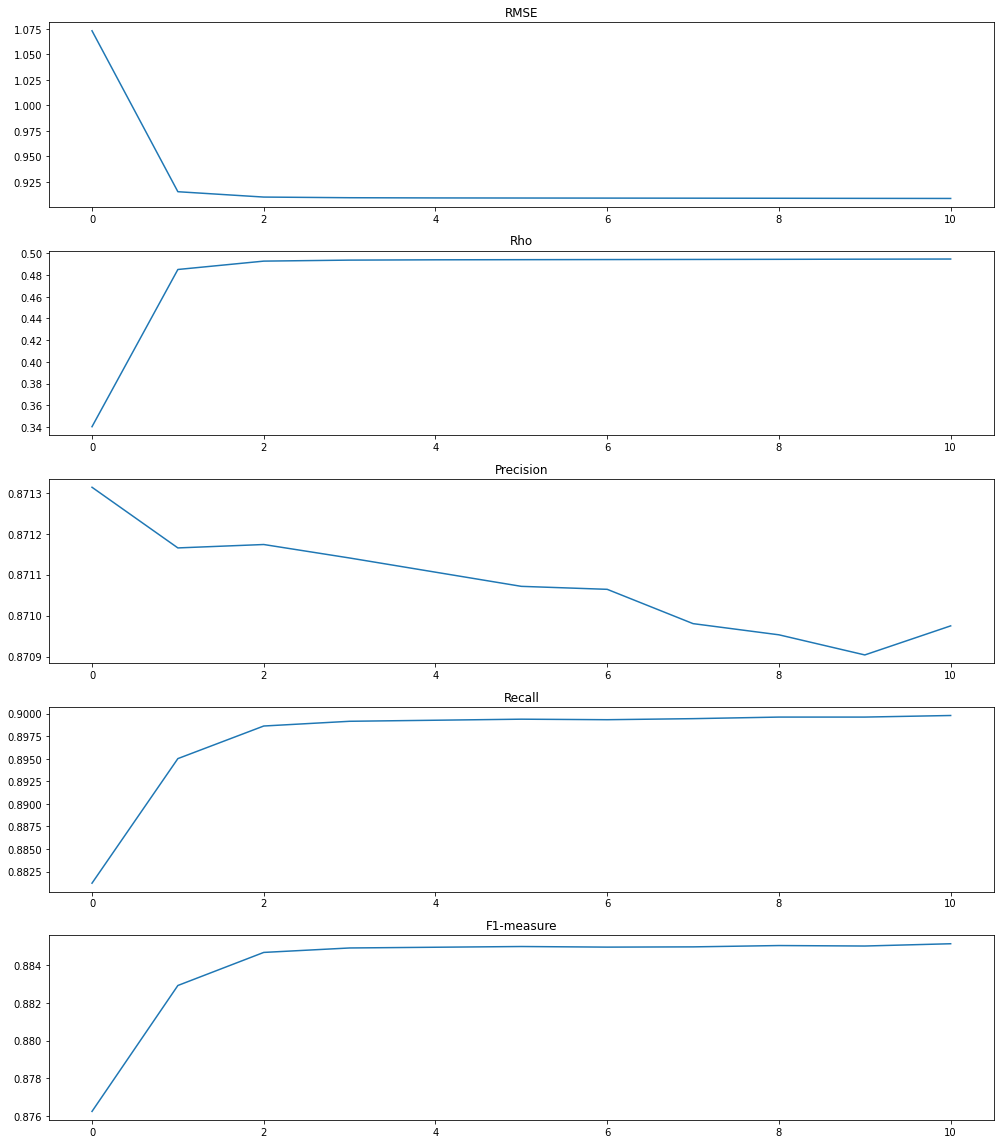

In [ ]:
# Show the variations 
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig , axis = plt.subplots(5 , 1 , figsize = (14 , 16))

axis[0].plot(RMSE_list)
axis[0].set_title("RMSE")

axis[1].plot(rho_list)
axis[1].set_title("Rho")

axis[2].plot(precision_list)
axis[2].set_title("Precision")

axis[3].plot(recall_list)
axis[3].set_title("Recall")

axis[4].plot(f1_score_list)
axis[4].set_title("F1-measure")